# Density estimation


## Introduction

- Last week we looked a Bayes decision theory
- Nice theoretically, but assumes knolwedge about probablity desnity distribution.
- This is rarely available, so how to we proceed.
- Estimate densities from data!

In this lecture we will cover
- Parametric density estimation
    - Maximum likelihood
- Non-parametric density estimation
    - Histogram approach
    - Parzen window approach
    - K nearest neighbor approach
- K nearest neighbor classifier

In [15]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, uniform, beta

---

## Parametric density estimation

### Why is stationarity important?

- Stationarity is a fundamental assumption in many time series forecasting models.
- Without it many basic time series models would break.
- Transformations can be applied to convert a nonstationary time series to a stationary one.
- There are advanced time series models that can handle nonstationary data (beyond the scope of this lecture).

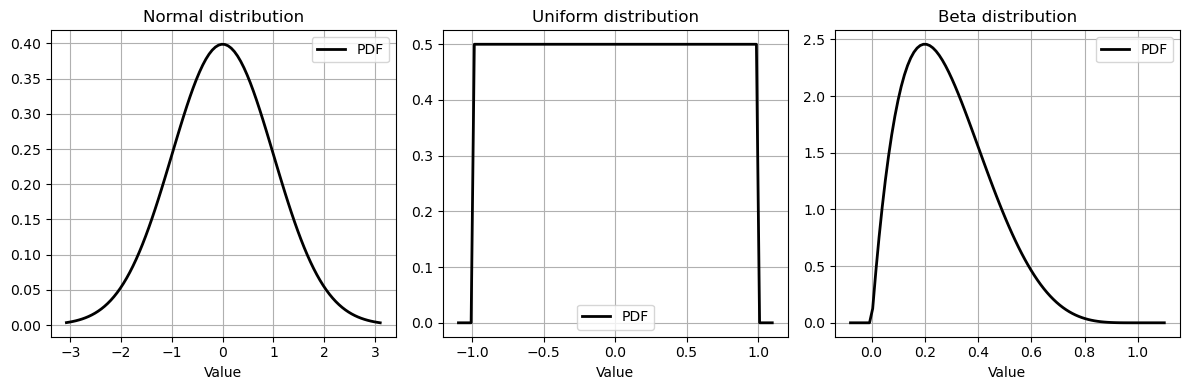

In [18]:
# Visualizing different distributions

normal_data = np.random.normal(loc=0, scale=1, size=1000)
uniform_data = np.random.uniform(low=-1, high=1, size=1000)
beta_data = np.random.beta(a=2, b=5, size=1000)
    
x_normal = np.linspace(normal_data.min()-0.1, normal_data.max()+0.1, 100)
p_normal = norm.pdf(x_normal, loc=0, scale=1)

x_uniform = np.linspace(uniform_data.min()-0.1, uniform_data.max()+0.1, 100)
p_uniform = uniform.pdf(x_uniform, loc=-1, scale=2)

x_beta = np.linspace(beta_data.min()-0.1, uniform_data.max()+0.1, 100)
p_beta = beta.pdf(x_beta, a=2, b=5)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(x_normal, p_normal, 'k', linewidth=2, label='PDF')
plt.xlabel('Value')
plt.title('Normal distribution')
plt.legend()
plt.grid(True)
plt.subplot(132)
plt.plot(x_uniform, p_uniform, 'k', linewidth=2, label='PDF')
plt.xlabel('Value')
plt.title('Uniform distribution')
plt.legend()
plt.grid(True)
plt.subplot(133)
plt.plot(x_beta, p_beta, 'k', linewidth=2, label='PDF')
plt.xlabel('Value')
plt.title('Beta distribution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Recall
    - 

### Likelihood function

- Let $\{\mathbf{x}_1, \cdots, \mathbf{x}_N\}$ and assume independent and identically distributed random variables (iid).
- Let the set of parameters for a particular distribution form a parameter vector $\boldsymbol{\theta}$.
- The likelihood function of $\boldsymbol{\theta}$ with respect to the random variable $X$ can be expressed as:
    - $p(X; \boldsymbol{\theta})=\prod\limits_{i=1}^N p(\mathbf{x}_i; \boldsymbol{\theta})$
- Idea:
    - Find $\boldsymbol{\theta}$ that makes $X$ most probable.
- Therefore:
    - $\hat{\boldsymbol{\theta}}_{ML} = $

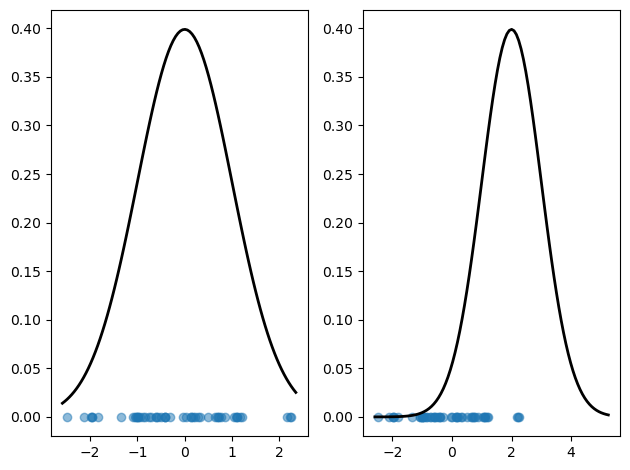

In [26]:
# Visualizing different distributions

normal_data = np.random.normal(loc=0, scale=1, size=50)

x_normal_good = np.linspace(normal_data.min()-0.1, normal_data.max()+0.1, 100)
p_normal_good = norm.pdf(x_normal_good, loc=0, scale=1)

x_normal_bad = np.linspace(normal_data.min()-0.1, normal_data.max()+3.0, 100)
p_normal_bad = norm.pdf(x_normal_bad, loc=2, scale=1)

plt.figure(1)
plt.subplot(121)
plt.scatter(normal_data, np.zeros_like(normal_data), alpha=0.5)
plt.plot(x_normal_good, p_normal_good, 'k', linewidth=2, label='PDF')
plt.subplot(122)
plt.scatter(normal_data, np.zeros_like(normal_data), alpha=0.5)
plt.plot(x_normal_bad, p_normal_bad, 'k', linewidth=2, label='PDF')
plt.tight_layout()
plt.show()

### Log-likelihood

